In [1]:
import pandas as pd
import numpy as np
import matplotlib
import sklearn
import math
import seaborn as sns
color = sns.color_palette()
from sklearn import preprocessing#, preprocessing
from matplotlib import pyplot as plt
from matplotlib import pylab as plb
from matplotlib import cm as cm
%matplotlib inline

## Clear data

#### Обрабатываются следующие фичи:  
* price_doc: sale price  
* id: transaction id  
* timestamp
* full_sq
* life_sq
* floor
* max_floor
* material
* build_year
* num_room
* kitch_sq
* state
* product_type 
* sub_area

In [2]:
train = pd.read_csv("train.csv", encoding= "utf_8")
test = pd.read_csv("test.csv", encoding= "utf_8")
print "Train size = ", len(train)
print "Test size = ", len(test)

Train size =  30471
Test size =  7662


<b>Декоратор для суммирования количества зааффекченых строк</b>

In [3]:
trainSize = len(train)
def counter(f):
    def wrapper(*args, **kwargs):
        wrapper.total += len(args[0])
        print "Total rows affected: ", wrapper.total
        print "% of train total: ", 100.0*round(float(wrapper.total) / float(trainSize), 3)
        return f(*args, **kwargs)
    wrapper.total = 0
    return wrapper

In [4]:
@counter
def amount(x):
    print "Rows affected on this cleaning: ", len(x)
    print "% of train on this cleaning: ", 100.0*round(float(len(x)) / float(trainSize), 3)

In [5]:
first_feat = ["id","timestamp", "price_doc", "full_sq", "life_sq",
"floor", "max_floor", "material", "build_year", "num_room",
"kitch_sq", "state", "product_type", "sub_area"]

### Что проверяем:

#### IF LIFE SQ >= FULL SQ => FULL SQ NP.NAN

In [6]:
bad_index = train[train.life_sq > train.full_sq].index
train.ix[bad_index, "life_sq"] = np.NaN
amount(bad_index)

Total rows affected:  37
% of train total:  0.1
Rows affected on this cleaning:  37
% of train on this cleaning:  0.1


In [7]:
equal_index = [601,1896,2791]
# print (test.ix[equal_index])
test.ix[equal_index, "life_sq"] = test.ix[equal_index, "full_sq"]

In [8]:
bad_index = test[test.life_sq > test.full_sq].index
test.ix[bad_index, "life_sq"] = np.NaN

#### IF LIFE SQ < 5 NP.NAN   

In [9]:
bad_index = train[train.life_sq < 5].index
train.ix[bad_index, "life_sq"] = np.NaN
amount(bad_index)

Total rows affected:  472
% of train total:  1.5
Rows affected on this cleaning:  435
% of train on this cleaning:  1.4


In [10]:
bad_index = test[test.life_sq < 5].index
test.ix[bad_index, "life_sq"] = np.NaN

#### IF FULL SQ < 5 NP.NAN  

In [11]:
bad_index = train[train.full_sq < 5].index
train.ix[bad_index, "full_sq"] = np.NaN
amount(bad_index)

Total rows affected:  498
% of train total:  1.6
Rows affected on this cleaning:  26
% of train on this cleaning:  0.1


In [12]:
bad_index = test[test.full_sq < 5].index
test.ix[bad_index, "full_sq"] = np.NaN

#### kitch_is_build_year lost

In [13]:
kitch_is_build_year = [13117]
train.ix[kitch_is_build_year, "build_year"] = train.ix[kitch_is_build_year, "kitch_sq"]
amount(bad_index)

Total rows affected:  501
% of train total:  1.6
Rows affected on this cleaning:  3
% of train on this cleaning:  0.0


#### KITCH SQ < LIFE SQ  

In [14]:
bad_index = train[train.kitch_sq >= train.life_sq].index
train.ix[bad_index, "kitch_sq"] = np.NaN
amount(bad_index)

Total rows affected:  579
% of train total:  1.9
Rows affected on this cleaning:  78
% of train on this cleaning:  0.3


In [15]:
bad_index = test[test.kitch_sq >= test.life_sq].index
test.ix[bad_index, "kitch_sq"] = np.NaN

#### IF KITCH SQ == 0 OR 1 NP.NAN  

In [16]:
bad_index = train[(train.kitch_sq == 0).values + (train.kitch_sq == 1).values].index
train.ix[bad_index, "kitch_sq"] = np.NaN
amount(bad_index)

Total rows affected:  6814
% of train total:  22.4
Rows affected on this cleaning:  6235
% of train on this cleaning:  20.5


In [17]:
bad_index = test[(test.kitch_sq == 0).values + (test.kitch_sq == 1).values].index
test.ix[bad_index, "kitch_sq"] = np.NaN

#### OUTLIERS IN LIFE SQ, FULL SQ AND KITCH SQ 
LIFE SQ / FULL SQ >= 0.3 too

In [18]:
bad_index = train[(train.full_sq > 210) & (train.life_sq / train.full_sq < 0.3)].index
train.ix[bad_index, "full_sq"] = np.NaN
amount(bad_index)

Total rows affected:  6821
% of train total:  22.4
Rows affected on this cleaning:  7
% of train on this cleaning:  0.0


In [19]:
bad_index = test[(test.full_sq > 150) & (test.life_sq / test.full_sq < 0.3)].index
test.ix[bad_index, "full_sq"] = np.NaN

In [20]:
bad_index = train[train.life_sq > 300].index
train.ix[bad_index, ["life_sq", "full_sq"]] = np.NaN
amount(bad_index)

Total rows affected:  6824
% of train total:  22.4
Rows affected on this cleaning:  3
% of train on this cleaning:  0.0


In [21]:
bad_index = test[test.life_sq > 200].index
test.ix[bad_index, ["life_sq", "full_sq"]] = np.NaN

### BUILDYEAR

In [22]:
train.product_type.value_counts(normalize= True)

Investment       0.638246
OwnerOccupier    0.361754
Name: product_type, dtype: float64

In [23]:
test.product_type.value_counts(normalize= True)

Investment       0.652310
OwnerOccupier    0.343383
Name: product_type, dtype: float64

In [24]:
bad_index = train[train.build_year < 1800].index
train.ix[bad_index, "build_year"] = np.NaN
amount(bad_index)

Total rows affected:  7728
% of train total:  25.4
Rows affected on this cleaning:  904
% of train on this cleaning:  3.0


In [25]:
bad_index = test[test.build_year < 1500].index
test.ix[bad_index, "build_year"] = np.NaN

### NUM OF ROOMS
* Выброс? Очень мало \ много ?
* LIFE SQ / ROOM > MIN ROOM SQ - а где комнаты побольше?
* IF NUM ROOM == 0 => TO NP.NAN

In [26]:
bad_index = train[train.num_room == 0].index 
train.ix[bad_index, "num_room"] = np.NaN
amount(bad_index)

Total rows affected:  7742
% of train total:  25.4
Rows affected on this cleaning:  14
% of train on this cleaning:  0.0


In [27]:
bad_index = test[test.num_room == 0].index 
test.ix[bad_index, "num_room"] = np.NaN

In [28]:
bad_index = [10076, 11621, 17764, 19390, 24007, 26713, 29172]
train.ix[bad_index, "num_room"] = np.NaN
amount(bad_index)

Total rows affected:  7749
% of train total:  25.4
Rows affected on this cleaning:  7
% of train on this cleaning:  0.0


In [29]:
bad_index = [3174, 7313]
test.ix[bad_index, "num_room"] = np.NaN

###  FLOOR & MAX FLOOR
* FLOOR == 0 & MAX FLOOR == 0 возможно ли? 
* IF FLOOR > MAX FLOOR -> MAX FLOOR NP.NAN, хотя спорно - надо районировать
* Выбросы

In [30]:
bad_index = train[(train.floor == 0).values & (train.max_floor == 0).values].index
train.ix[bad_index, ["max_floor", "floor"]] = np.NaN
amount(bad_index)

Total rows affected:  7753
% of train total:  25.4
Rows affected on this cleaning:  4
% of train on this cleaning:  0.0


In [31]:
bad_index = train[train.floor == 0].index
train.ix[bad_index, "floor"] = np.NaN
amount(bad_index)

Total rows affected:  7758
% of train total:  25.5
Rows affected on this cleaning:  5
% of train on this cleaning:  0.0


In [32]:
bad_index = train[train.max_floor == 0].index
train.ix[bad_index, "max_floor"] = np.NaN
amount(bad_index)

Total rows affected:  8304
% of train total:  27.3
Rows affected on this cleaning:  546
% of train on this cleaning:  1.8


In [33]:
bad_index = test[test.max_floor == 0].index
test.ix[bad_index, "max_floor"] = np.NaN

In [34]:
bad_index = train[train.floor > train.max_floor].index
train.ix[bad_index, "max_floor"] = np.NaN
amount(bad_index)

Total rows affected:  9251
% of train total:  30.4
Rows affected on this cleaning:  947
% of train on this cleaning:  3.1


In [35]:
bad_index = test[test.floor > test.max_floor].index
test.ix[bad_index, "max_floor"] = np.NaN

In [36]:
train.floor.describe(percentiles= [0.9999])

count     30295.000000
mean          7.673081
std           5.319135
min           1.000000
50%           7.000000
100.0%       40.911800
max          77.000000
Name: floor, dtype: float64

In [37]:
bad_index = [23584]
train.ix[bad_index, "floor"] = np.NaN
amount(bad_index)

Total rows affected:  9252
% of train total:  30.4
Rows affected on this cleaning:  1
% of train on this cleaning:  0.0


### MATERIAL
1 - panel, 2 - brick, 3 - wood, 4 - mass concrete, 5 - breezeblock, 6 - mass concrete + brick

In [38]:
train.material.value_counts()

1.0    14197
2.0     2993
5.0     1561
4.0     1344
6.0      803
3.0        1
Name: material, dtype: int64

In [39]:
test.material.value_counts()

1    5241
2     958
4     619
5     487
6     356
3       1
Name: material, dtype: int64

### STATE
4 - the best -> 1 - the worst

In [40]:
train.state.value_counts()

2.0     5844
3.0     5790
1.0     4855
4.0      422
33.0       1
Name: state, dtype: int64

In [41]:
bad_index = train[train.state == 33].index
train.ix[bad_index, "state"] = np.NaN
amount(bad_index)

Total rows affected:  9253
% of train total:  30.4
Rows affected on this cleaning:  1
% of train on this cleaning:  0.0


In [42]:
test.state.value_counts()

2.0    2662
1.0    2266
3.0    1913
4.0     127
Name: state, dtype: int64

### SAVE CLEAN
ToDO: need to choose best add na_rep, something like : test.to_csv('c:\temp\test_synthetic_v3.csv',na_rep='NA',index=False)

In [43]:
test.to_csv("test_clean.csv", na_rep='NA', index= False, encoding= "utf_8")
train.to_csv("train_clean.csv", na_rep='NA', index = False, encoding= "utf_8")

## Ещё один подход к очистке датасетов (попытка агрегации по районам)

Чтобы прогнозировать цену m^2, можно ввести фиктивную колонку price/full_sq

In [44]:
train = pd.read_csv("train.csv", encoding= "utf_8")
test = pd.read_csv("test.csv", encoding= "utf_8")
n=train.shape[0]
test.price_doc=np.nan
ids=test['id']
target=train.price_doc
train=train.append(test)

In [45]:
a=train.sub_area.unique()
for i in a:
    if train[(train['floor'].isnull()) & (train['sub_area']==i)].shape[0]>0:
        train.loc[(train['floor'].isnull()) & (train['sub_area']==i),'floor']=train.loc[(train['floor'].notnull()) & (train['sub_area']==i),'floor'].mode().values[0]
print('floors done',train['product_type'].value_counts())

('floors done', Investment       24446
OwnerOccupier    13654
Name: product_type, dtype: int64)


Заполним nan средними по району (может пригодиться для алгоритмов, где nan неприемлемы)

In [46]:
for i in a:
    if train[(train['max_floor'].isnull()) & (train['sub_area']==i)].shape[0]>0:
        if i=='Poselenie Shhapovskoe':
            train.loc[(train['max_floor'].isnull()) & (train['sub_area']==i),'max_floor']=train.loc[(train['max_floor'].notnull()) & (train['sub_area']==i),'max_floor'].median()
        else:
            train.loc[(train['max_floor'].isnull()) & (train['sub_area']==i),'max_floor']=train.loc[(train['max_floor'].notnull()) & (train['sub_area']==i),'max_floor'].mode().values[0]

### build year
Некоторые районы образовались недавно. Стройки там до этого можно считать выбросами (вероятно их мало, т.к. недостаток инфраструктуры и транспорта, но стоит проверить, чтобы точно)

In [47]:
for i in a:
    if train[(train['build_year'].isnull()) & (train['sub_area']==i)].shape[0]>0:
        if i=='Poselenie Voronovskoe':
            train.loc[(train['build_year'].isnull()) & (train['sub_area']==i),'build_year']=2014
        elif i=='Poselenie Shhapovskoe':
            train.loc[(train['build_year'].isnull()) & (train['sub_area']==i),'build_year']=2011
        else:
            train.loc[(train['build_year'].isnull()) & (train['sub_area']==i),'build_year']=train.loc[(train['build_year'].notnull()) & (train['sub_area']==i),'build_year'].mode().values[0]


### materials

In [48]:
for i in a:
    if train[(train['material'].isnull()) & (train['sub_area']==i)].shape[0]>0:
        train.loc[(train['material'].isnull()) & (train['sub_area']==i),'material']=train.loc[(train['material'].notnull()) & (train['sub_area']==i),'material'].mode().values[0]

### state

In [49]:
for i in a:
    if train[(train['state'].isnull()) & (train['sub_area']==i)].shape[0]>0:
        if (i=='Poselenie Klenovskoe' or i=='Poselenie Kievskij'):
            train.loc[(train['state'].isnull()) & (train['sub_area']==i),'state']=2
        else:
            train.loc[(train['state'].isnull()) & (train['sub_area']==i),'state']=train.loc[(train['state'].notnull()) & (train['sub_area']==i),'state'].mode().values[0]

### railroads

In [50]:
cols=['ID_railroad_station_walk','ID_railroad_station_avto','green_part_2000','metro_km_walk','metro_min_walk']
for j in cols:
    for i in a:
        if train[(train[j].isnull()) & (train['sub_area']==i)].shape[0]>0:
            train.loc[(train[j].isnull()) & (train['sub_area']==i),j]=train.loc[(train[j].notnull()) & (train['sub_area']==i),j].mode().values[0]
cols=['railroad_station_walk_km','railroad_station_walk_min']
for j in cols:
    for i in a:
        if train[(train[j].isnull()) & (train['sub_area']==i)].shape[0]>0:
            train.loc[(train[j].isnull()) & (train['sub_area']==i),j]=train.loc[(train[j].notnull()) & (train['sub_area']==i),j].median()

### rooms & spacing

In [51]:
# логичнее заполнить пропуски на основании хотя бы примитивной линейной модели, чем на основании среднего
x=train.loc[(train.full_sq.notnull())&(train.num_room.notnull()),'full_sq']
y=train.loc[(train.full_sq.notnull())&(train.num_room.notnull()),'num_room']
rooms=np.polyfit(x,y,1)
train.loc[train['num_room'].isnull(),'num_room']=train.loc[train['num_room'].isnull(),'full_sq']*rooms[0]+rooms[1]

# логичнее заполнить пропуски на основании хотя бы примитивной линейной модели, чем на основании среднего
x=train.loc[(train.kitch_sq.notnull())&(train.kitch_sq.notnull()),'full_sq']
y=train.loc[(train.kitch_sq.notnull())&(train.kitch_sq.notnull()),'kitch_sq']
kitch=np.polyfit(x,y,1)
train.loc[train['kitch_sq'].isnull(),'kitch_sq']=train.loc[train['kitch_sq'].isnull(),'full_sq']*kitch[0]+kitch[1]

# логичнее заполнить пропуски на основании хотя бы примитивной линейной модели, чем на основании среднего
x=train.loc[(train.full_sq.notnull())&(train.life_sq.notnull()),'full_sq']
y=train.loc[(train.full_sq.notnull())&(train.life_sq.notnull()),'life_sq']
life=np.polyfit(x,y,1)
train.loc[train['life_sq'].isnull(),'life_sq']=train.loc[train['life_sq'].isnull(),'full_sq']*life[0]+life[1]
# уберём выбросы
train.loc[(train['life_sq']>train['full_sq'])&(train['life_sq']>1000),'life_sq']=train.loc[(train['life_sq']>train['full_sq'])&(train['life_sq']>1000),'life_sq']/1000
train.loc[(train['life_sq']>train['full_sq'])&(train['life_sq']>106),'life_sq']=train.loc[(train['life_sq']>train['full_sq'])&(train['life_sq']>106),'life_sq']/100
print('fits done',train['product_type'].value_counts())

('fits done', Investment       24446
OwnerOccupier    13654
Name: product_type, dtype: int64)


### Город \ Район
Брались средние значения, можно попробовать кластеризовать, например, по районам

In [52]:
cols=['build_count_1921-1945','build_count_1946-1970','build_count_1971-1995','build_count_after_1995','build_count_before_1920',
'build_count_block','build_count_brick','build_count_foam','build_count_frame','build_count_mix','build_count_monolith',
'build_count_panel','build_count_slag','build_count_wood','cafe_avg_price_1000','cafe_avg_price_1500','cafe_avg_price_2000',
'cafe_avg_price_3000','cafe_avg_price_500','cafe_avg_price_5000','cafe_sum_1000_max_price_avg','cafe_sum_1000_min_price_avg',
'cafe_sum_1500_max_price_avg','cafe_sum_1500_min_price_avg','cafe_sum_2000_max_price_avg','cafe_sum_2000_min_price_avg',
'cafe_sum_3000_max_price_avg','cafe_sum_3000_min_price_avg','cafe_sum_5000_max_price_avg','cafe_sum_5000_min_price_avg',
'cafe_sum_500_max_price_avg','cafe_sum_500_min_price_avg','raion_build_count_with_builddate_info','raion_build_count_with_material_info','prom_part_5000']
for j in cols:
    train.loc[train[j].isnull(),j]=train.loc[train[j].notnull(),j].median()
            
print('city data done',train['product_type'].value_counts())

('city data done', Investment       24446
OwnerOccupier    13654
Name: product_type, dtype: int64)


#### больницы и дет. сады

In [53]:
i='raion_popul'
j='hospital_beds_raion'
x=train.loc[(train[i].notnull())&(train[j].notnull()),i]
y=train.loc[(train[i].notnull())&(train[j].notnull()),j]
fit=np.polyfit(x,y,1)
train.loc[train[j].isnull(),j]=train.loc[train[j].isnull(),i]*fit[0]+fit[1]

i='children_preschool'
j='preschool_quota'
x=train.loc[(train[i].notnull())&(train[j].notnull()),i]
y=train.loc[(train[i].notnull())&(train[j].notnull()),j]
fit=np.polyfit(x,y,1)
train.loc[train[j].isnull(),j]=train.loc[train[j].isnull(),i]*fit[0]+fit[1]

i='children_school'
j='school_quota'
x=train.loc[(train[i].notnull())&(train[j].notnull()),i]
y=train.loc[(train[i].notnull())&(train[j].notnull()),j]
fit=np.polyfit(x,y,1)
train.loc[train[j].isnull(),j]=train.loc[train[j].isnull(),i]*fit[0]+fit[1]

train.loc[train['product_type'].isnull(),'product_type']='Investment'

#### Экология:
4 - превосходная, 1 - печальная

In [54]:
binary=[]
for i in train:
    if train[i].dtypes=='object':
#         print("Объектов", train[i].value_counts())
        if train[i].value_counts().shape[0]==2:
            binary.append(i)
for i in binary:
    train[i]=pd.factorize(train[i])[0]
#change the echology to a 1-4 and ohe for NANs
train.loc[train['ecology']=='no data','ecology_dat']=0
train.loc[train['ecology']!='no data','ecology_dat']=1
train.loc[train['ecology']=='no data','ecology']=2
train.loc[train['ecology']=='poor','ecology']=1
train.loc[train['ecology']=='satisfactory','ecology']=2
train.loc[train['ecology']=='good','ecology']=3
train.loc[train['ecology']=='excellent','ecology']=4
train.ecology=pd.to_numeric(train.ecology)

train=pd.concat([train,pd.get_dummies(train.sub_area)],axis=1)
train=pd.concat([train,pd.get_dummies(train.material,prefix='material')],axis=1)
train.drop(['sub_area','material'],inplace=True,axis=1)

Посчитаем кол-во различных переменных в датасете

In [55]:
dtype_df = test.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,159
1,float64,116
2,object,16


Давайте определим, сколько в каждой колонке нехватающих величин

In [56]:
# missing_df = train.isnull().sum(axis=0).reset_index()
# missing_df.columns = ['column_name', 'missing_count']
# missing_df = missing_df.ix[missing_df['missing_count']>0]
# ind = np.arange(missing_df.shape[0])
# width = 0.9
# fig, ax = plt.subplots(figsize=(12,18))
# rects = ax.barh(ind, missing_df.missing_count.values, color='y')
# ax.set_yticks(ind)
# ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
# ax.set_xlabel("Count of missing values")
# ax.set_title("Number of missing values in each column")
# plt.show()

In [57]:
# train_na = (train.isnull().sum() / len(train)) * 100
# train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)
# f, ax = plt.subplots(figsize=(15, 8))
# plt.xticks(rotation='90')
# sns.barplot(x=train_na.index, y=train_na)
# ax.set(title='Percent missing data by feature', ylabel='% missing')

### Data Quality Issues

In [58]:
# Состояние может принимать значения от 1 до 4. 33 - явная ошибка. Заменим модой
train.loc[train['state'] == 33, 'state'] = train['state'].mode().iloc[0]

# build_year 20052009. Полагаю, это 2005-2009, так что заменим на 2007
train.loc[train['build_year'] == 20052009, 'build_year'] = 2007

In [59]:
internal_chars = ['full_sq', 'life_sq', 'floor', 'max_floor', 'build_year', 'num_room', 'kitch_sq', 'state', 'price_doc']
corrmat = train[internal_chars].corr()

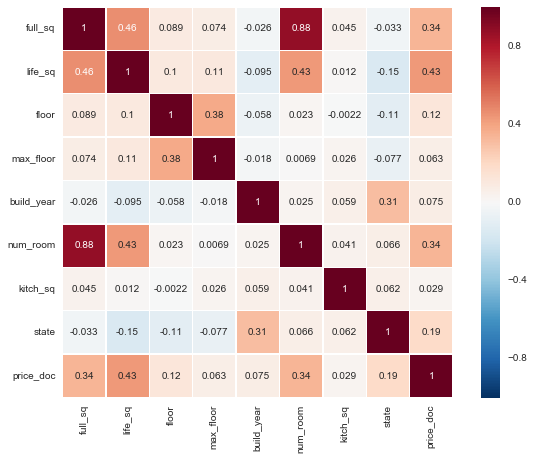

In [60]:
f, ax = plt.subplots(figsize=(10, 7))
plt.xticks(rotation='90')
sns.heatmap(corrmat, square=True, linewidths=.5, annot=True)